In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pickle
# 导入向量化后的数据集
np_vectorized_doc2vec = pickle.load(open('vectorized_generated_corpus_doc2vec.pkl', 'rb'))

In [3]:
np_vectorized_doc2vec[:10]

array([[ 2.89205345e-03, -8.08892597e-04,  8.15546606e-03,
         2.75301165e-03, -2.06303652e-04,  3.62663390e-03,
         2.09601549e-03, -6.57518348e-03,  7.35852215e-03,
         8.96254554e-03,  2.76255235e-03,  4.64767311e-03,
        -1.61031168e-03, -7.87248835e-03, -6.28709036e-04,
         2.22694036e-03, -7.67329475e-03,  2.63439328e-03,
         1.68644066e-04,  7.68062519e-03,  3.52390180e-03,
        -1.26587565e-03, -1.60900466e-02,  7.23800482e-03,
        -2.49217410e-04, -2.50085257e-03,  6.15369948e-03,
        -5.93211222e-03,  1.08864624e-02,  1.31676544e-03,
        -3.44674848e-03, -1.31698232e-03,  2.49618106e-03,
         1.84177384e-02,  2.72081629e-03, -4.40125586e-03,
         2.39745932e-04, -3.93963791e-03,  1.15586082e-02,
         3.69167840e-03,  4.17817011e-03,  5.27888024e-03,
         4.76419041e-03,  4.90524527e-03, -4.24468704e-03,
         6.18346455e-03,  6.33573974e-04,  5.80844330e-03,
         3.62944702e-04, -4.45647398e-04, -3.53119336e-0

In [15]:
np_vectorized_doc2vec = np_vectorized_doc2vec * 100

In [16]:
np_vectorized_doc2vec[:10]

array([[ 2.89205343e-01, -8.08892623e-02,  8.15546632e-01,
         2.75301158e-01, -2.06303652e-02,  3.62663388e-01,
         2.09601551e-01, -6.57518327e-01,  7.35852242e-01,
         8.96254539e-01,  2.76255250e-01,  4.64767307e-01,
        -1.61031172e-01, -7.87248850e-01, -6.28709048e-02,
         2.22694039e-01, -7.67329454e-01,  2.63439327e-01,
         1.68644059e-02,  7.68062532e-01,  3.52390170e-01,
        -1.26587570e-01, -1.60900462e+00,  7.23800480e-01,
        -2.49217413e-02, -2.50085264e-01,  6.15369976e-01,
        -5.93211234e-01,  1.08864629e+00,  1.31676540e-01,
        -3.44674855e-01, -1.31698236e-01,  2.49618113e-01,
         1.84177387e+00,  2.72081643e-01, -4.40125585e-01,
         2.39745937e-02, -3.93963784e-01,  1.15586078e+00,
         3.69167835e-01,  4.17816997e-01,  5.27888000e-01,
         4.76419032e-01,  4.90524530e-01, -4.24468696e-01,
         6.18346453e-01,  6.33573979e-02,  5.80844343e-01,
         3.62944715e-02, -4.45647389e-02, -3.53119344e-0

In [17]:
np_vectorized_doc2vec.shape

(1200, 100)

In [18]:
np_vectorized_doc2vec.dtype

dtype('float32')

In [19]:
# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = np_vectorized_doc2vec,
                                      batch_size = 32,
                                      shuffle = True)

In [26]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 100 ==> 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 12),
            torch.nn.ReLU(),
            torch.nn.Linear(12, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 2)
        )
        
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 2 ==> 100
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 12),
            torch.nn.ReLU(),
            torch.nn.Linear(12, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return (encoded, decoded) # encoded is the result of dimensionality reduction

In [84]:
# Model Initialization
model = AE()
model.cuda()  # move the model to GPU

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),
							lr = 0.01,
							weight_decay = 0.00000001)

In [85]:
epochs = 100
iters = 0
outputs = []
losses = []

for epoch in range(1, epochs + 1):
    print('Epoch:', epoch)
    for essay in loader:
        iters += 1

        essay = essay.cuda()  # move data to GPU

        # Output of Autoencoder
        _, reconstructed = model(essay)

        # Calculating the loss function
        loss = loss_function(reconstructed, essay)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.item())
        if iters % 100 == 0:
            print(f"Iteration: {iters}, loss is: {loss.item()}")

    outputs.append((epoch, essay, reconstructed))

Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 100, loss is: 1.645447850227356
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 200, loss is: 1.362356185913086
Epoch: 7
Epoch: 8
Iteration: 300, loss is: 0.9881527423858643
Epoch: 9
Epoch: 10
Epoch: 11
Iteration: 400, loss is: 1.1331238746643066
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 500, loss is: 1.0004386901855469
Epoch: 15
Epoch: 16
Iteration: 600, loss is: 0.9427986145019531
Epoch: 17
Epoch: 18
Epoch: 19
Iteration: 700, loss is: 1.193060278892517
Epoch: 20
Epoch: 21
Epoch: 22
Iteration: 800, loss is: 1.2050330638885498
Epoch: 23
Epoch: 24
Iteration: 900, loss is: 1.2256295680999756
Epoch: 25
Epoch: 26
Epoch: 27
Iteration: 1000, loss is: 0.9950260519981384
Epoch: 28
Epoch: 29
Iteration: 1100, loss is: 1.0912731885910034
Epoch: 30
Epoch: 31
Epoch: 32
Iteration: 1200, loss is: 1.1392881870269775
Epoch: 33
Epoch: 34
Epoch: 35
Iteration: 1300, loss is: 1.2903637886047363
Epoch: 36
Epoch: 37
Iteration: 1400, loss is: 1.9833554029464722
Epoch: 38
Epoch: 39
E

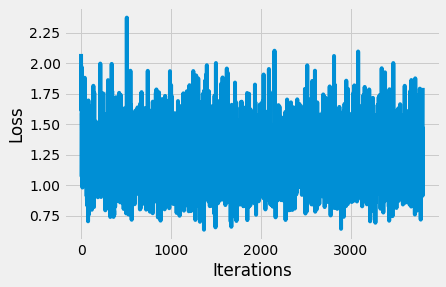

In [86]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [87]:
outputs[-1]

(100, tensor([[-0.0146, -0.3007,  0.9625,  ..., -1.1877,  0.8292,  0.0356],
         [-1.2036, -0.0158,  0.8119,  ..., -0.6129,  1.1718, -0.8752],
         [-0.9409, -0.1284,  1.1740,  ..., -1.4514,  0.6829, -1.9647],
         ...,
         [-0.9622, -0.7578,  0.7297,  ..., -1.0938,  0.6641, -0.9029],
         [-0.9362, -0.0301, -0.2777,  ..., -0.0487,  0.0172, -1.6102],
         [ 0.2907, -0.6905,  2.1165,  ..., -0.9152,  0.8764,  0.4853]],
        device='cuda:0'), tensor([[1.6776e-01, 5.8183e-05, 9.9995e-01,  ..., 5.3865e-05, 7.3036e-01,
          4.6185e-04],
         [1.6776e-01, 5.8183e-05, 9.9995e-01,  ..., 5.3865e-05, 7.3036e-01,
          4.6185e-04],
         [1.6776e-01, 5.8183e-05, 9.9995e-01,  ..., 5.3865e-05, 7.3036e-01,
          4.6185e-04],
         ...,
         [1.6776e-01, 5.8183e-05, 9.9995e-01,  ..., 5.3865e-05, 7.3036e-01,
          4.6185e-04],
         [1.6776e-01, 5.8183e-05, 9.9995e-01,  ..., 5.3865e-05, 7.3036e-01,
          4.6185e-04],
         [1.6776e-01

In [88]:
# Dimensionality Reduction by the trained AE model

decomposition_data = []
for essay in np_vectorized_doc2vec:
    essay = torch.from_numpy(essay).cuda()
    encoded, decoded = model(essay)
    decomposition_data.append(encoded.cpu().data.numpy())

decomposition_data = np.array(decomposition_data)

In [89]:
decomposition_data

array([[-0.11410143,  0.05229527],
       [-0.16129175,  0.03250541],
       [-0.12721413,  0.04684119],
       ...,
       [-0.13425028,  0.04388109],
       [-0.13558823,  0.04331833],
       [-0.19574678,  0.01849374]], dtype=float32)

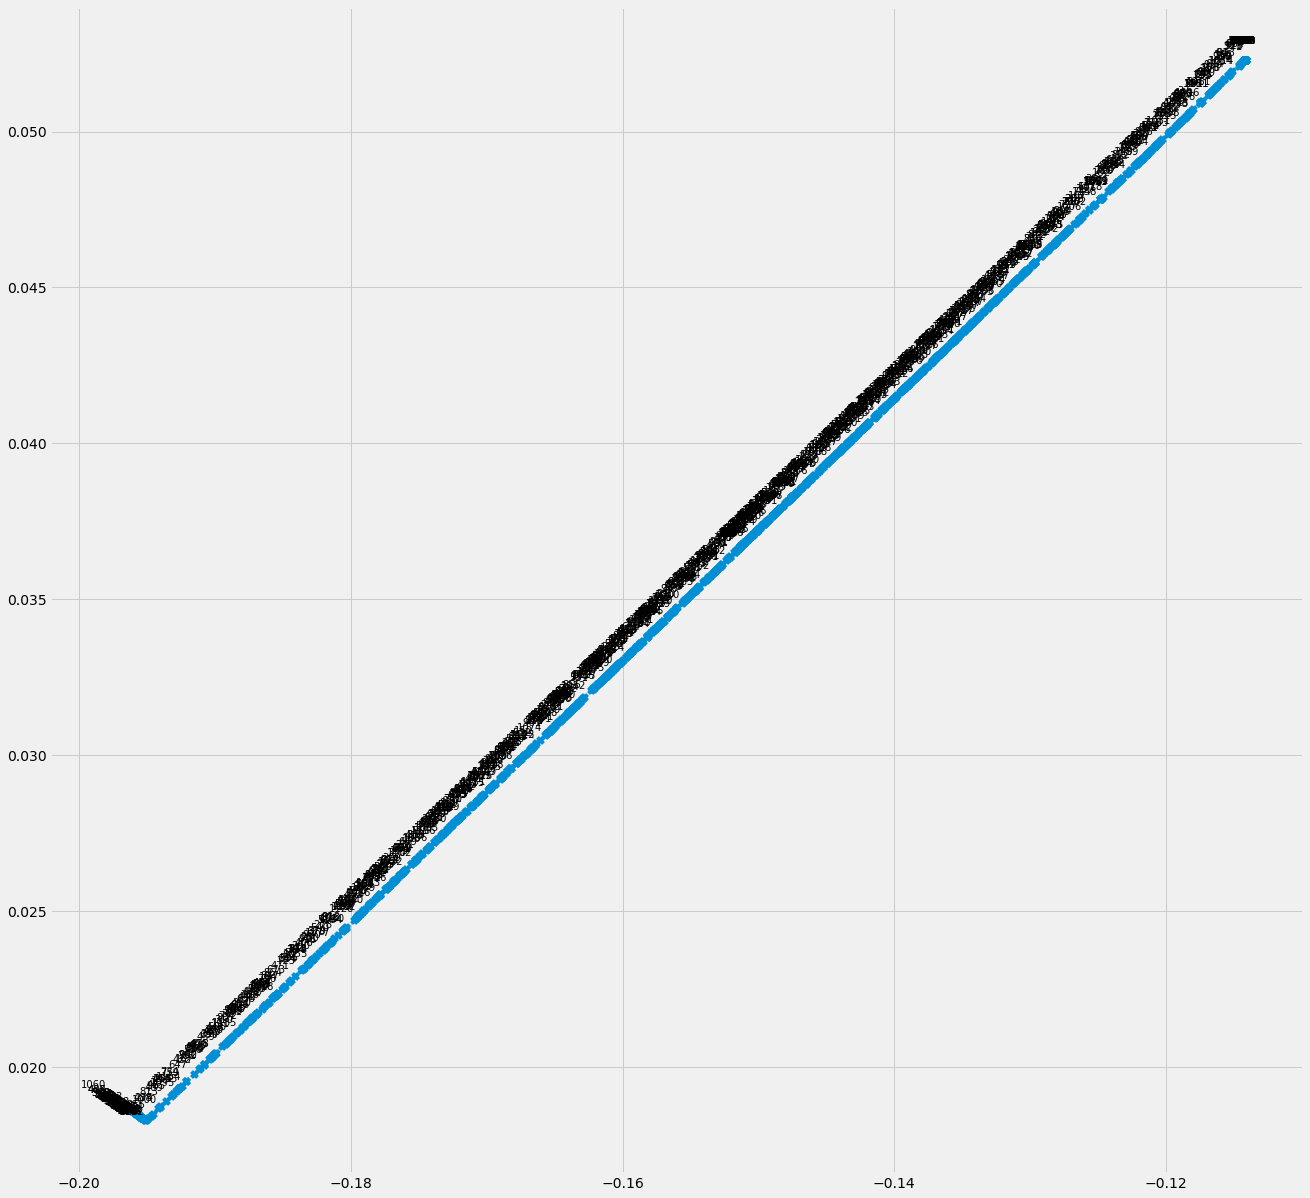

In [90]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], marker='x')
for i in range(len(decomposition_data)):
    plt.text(decomposition_data[:, 0][i] * 1.01, decomposition_data[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

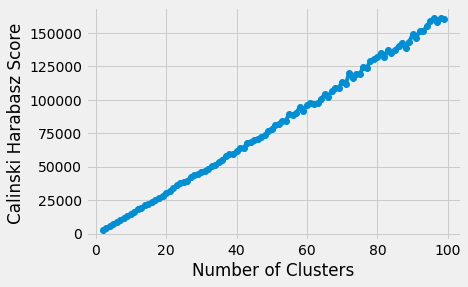

In [91]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [92]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

96

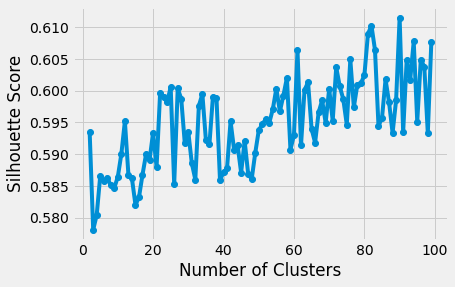

In [93]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [94]:
silhouette_score_list.index(max(silhouette_score_list))

88

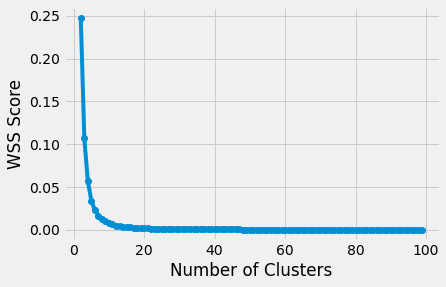

In [95]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

In [96]:
# 选用 k 值做 K-means 算法聚类
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [97]:
print(y_pred[:10])

[5 0 1 5 3 4 4 1 5 0]


In [98]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data[i]))

In [99]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

5 -0.11719263
0 -0.16095227
1 -0.13370636
3 -0.17536402
4 -0.14736661
2 -0.19233194


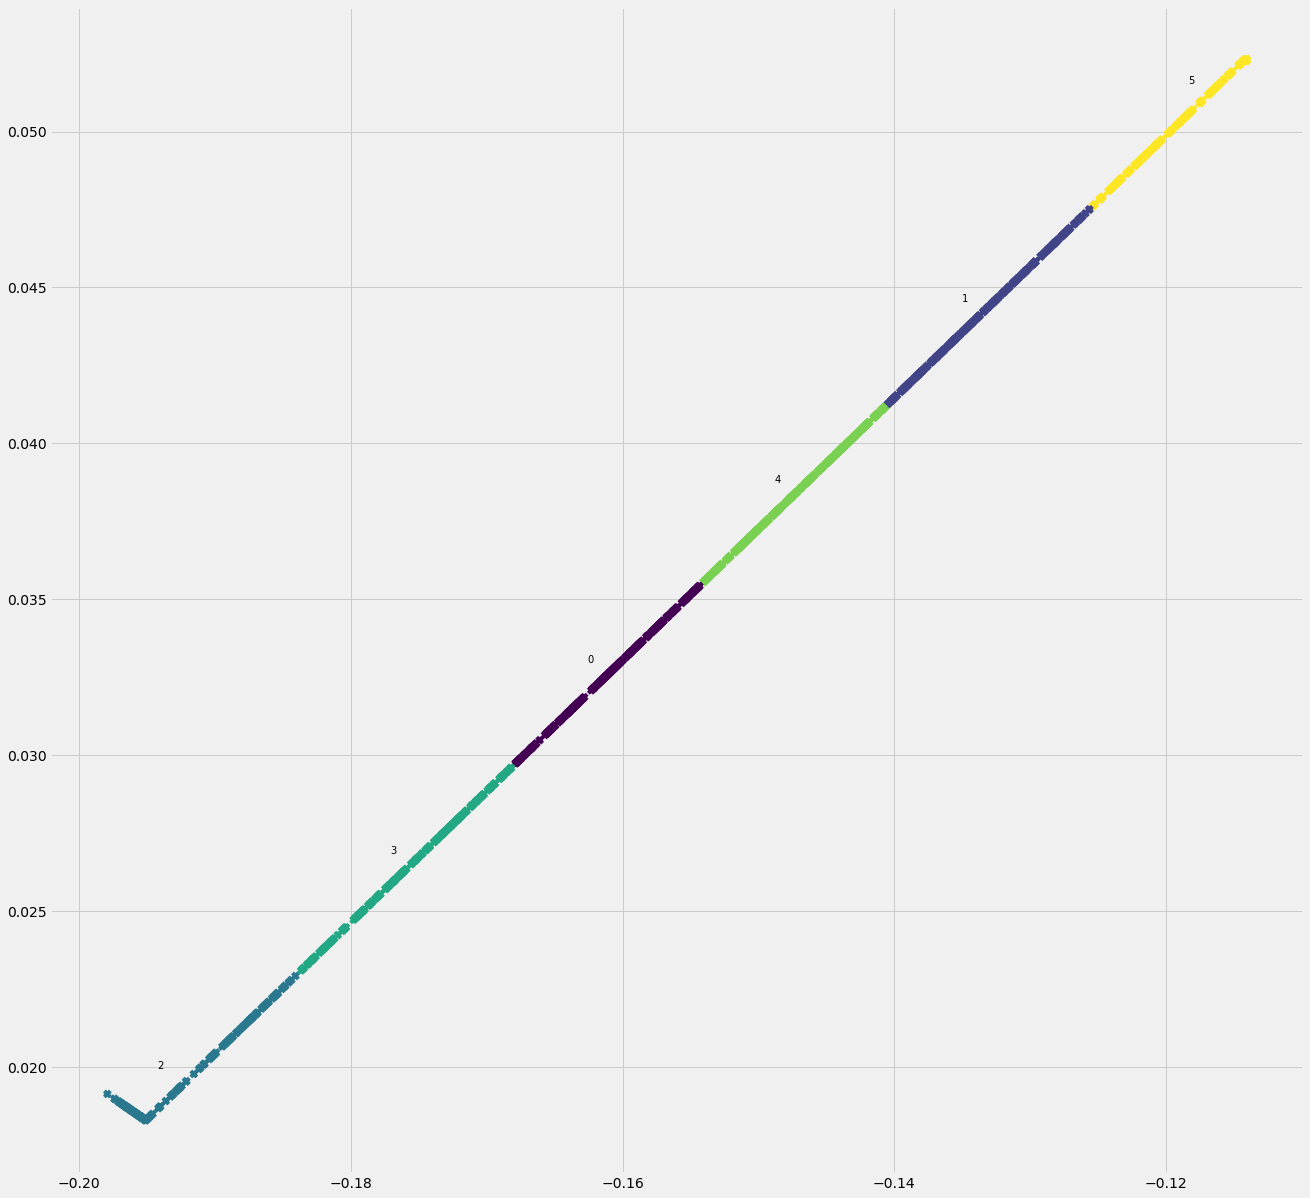

In [100]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data[:, 0], decomposition_data[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [101]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

8724.654115239156

In [102]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.58576584

In [103]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [104]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [105]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.homogeneity_score(labels, y_pred)

0.04547622994465538

In [106]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.completeness_score(labels, y_pred)

0.04572845198942776

In [107]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.v_measure_score(labels, y_pred)

0.04560199221323567

In [108]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.026221000619048026

In [109]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

0.03996539814965817

In [110]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 Word2vec 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.1894139342175853